## Using iDeLUCS code in your python scripts

Clustering DNA sequences is hard. In particular, iDeLUCS operates under the assumption that the $k$-mer based genomic signature is pervasive across the genome and is enough to differentiate organisms at various taxonomic levels. In this notebook I will describe how you can import the functions and use them within your code. 

### Import the Libraries

In [1]:
import sys


import numpy as np
import matplotlib.pyplot as plt 
import umap


sys.path.append('../')
from idelucs.utils import SummaryFasta, kmersFasta, cluster_acc
from idelucs.cluster import iDeLUCS_cluster


### Select the input files

Here we are using the `Influenza-A.fas` dataset as sample. The `SummaryFasta` fuction is used to scan the dataset and the `kmersFasta` is used to compute the 6-mers histogram and visualize how hard is to compute is our dataset.  We are using UMAP to visualize the dataset and we are including the labels as color, but that is not required.

The cluster distribution is:
{'H7N3': 193, 'H1N1': 191, 'H7N9': 190, 'H5N1': 188, 'H2N2': 187}
No. Sequences: 	 949
Min. Length: 	 1,345
Max. Length: 	 1,468
Avg. Length: 	 1,409.29
(949, 4096)
..... Visualization of the dataset ....


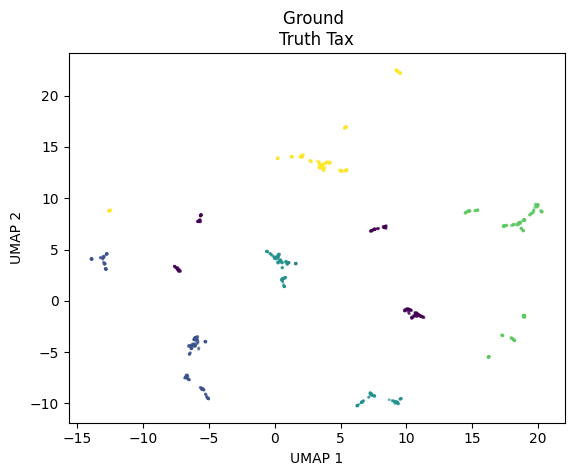

In [7]:
fasta_file = "Influenza-A.fas"
GT_file = "Influenza-A_GT.tsv"
k = 6

names, lengths, ground_truth, cluster_dis =  SummaryFasta(fasta_file, GT_file=GT_file)

print("The cluster distribution is:")
print (cluster_dis)


stats = {"n_seq": len(lengths),
        "min_len": np.min(lengths),
        "max_len": np.max(lengths),
        "avg_len": np.mean(lengths)}

print( f'No. Sequences: \t {stats["n_seq"]:,}')
print(f'Min. Length: \t {stats["min_len"]:,}')
print(f'Max. Length: \t {stats["max_len"]:,}')
print(f'Avg. Length: \t {round(stats["avg_len"],2):,}')


_, kmers = kmersFasta(fasta_file, k=k, transform=None, reduce=False)
unique = sorted(list(set(ground_truth)))
GT = list(map(lambda x: unique.index(x), ground_truth))

print(kmers.shape)

print("..... Visualization of the dataset ....")

# Find UMAP embedding    
embedding = umap.UMAP(random_state=42).fit_transform(kmers)
          
#plt.subplot(2, 2, 1)
plt.title("Ground \nTruth Tax")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.scatter(embedding[:,0],
            embedding[:,1],
            c = GT,
            s=1.5,
            alpha=0.5)

plt.show()


### Clustering the dataset

In [5]:
n_cluster = 5

params = {
    "iDeLUCS": {'sequence_file':fasta_file,'n_clusters':n_cluster, 'n_epochs':10,
                'n_mimics':3, 'batch_sz':512, 'k':k, 'weight':0.75, 'n_voters':5},
    }

# Definition of the clustering algorithms for now only iDeLUCS but you can add otehr to compare
clustering_algorithms = (
    ("iDeLUCS", iDeLUCS_cluster),
)

print("....Let's start clustering..........." )

for name, algorithm in clustering_algorithms:

    print(f'....{name}...')
                    
    model = algorithm(**params[name])
    y_pred, latent = model.fit_predict(fasta_file )
    
ind, d = cluster_acc(np.array(GT).reshape(-1,1), y_pred)
print(f"\n The accuracy of the model is: {d}")

....Let's start clustering...........
....iDeLUCS...
........... Training Model (5/5)................The accuracy of the model is: 0.9304531085353003


### We can also visualize the embedding

/home/loan/dev_iDeLUCS/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


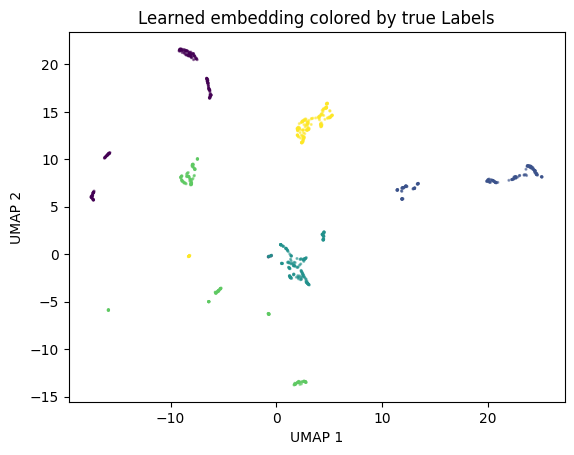

In [6]:
# Find UMAP embedding    
embedding = umap.UMAP(random_state=42).fit_transform(latent)
          
#plt.subplot(2, 2, 1)
plt.title("Learned embedding colored by true Labels")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.scatter(embedding[:,0],
            embedding[:,1],
            c = GT,
            s=1.5,
            alpha=0.5)
plt.show()